# Figure 5

This notebook creates Figure 5. 

(For my own records, this is derived from yellowstone/Notebooks/wavenumber_frequency_testing.ipynb. I have also copied `wavenumber_frequency_functions.py` into this repository for archival purposes. The maintained version is in [GitHub/wavenumber_frequency](https://github.com/brianpm/wavenumber_frequency).)

Changes in wavenumber-frequency power spectra with LWoff. Color shading in each panel shows the percent difference, expressed as 100*(LWoff - Control)/Control, of the non-normalized zonal wavenumber-frequency power spectra for the precipitation component symmetric about the equator for each model simulation. White contours show the associated spectral power using log base-10 scaling from the associated control simulation as a reference (contour interval is 0.15 up to 1.2).  
    Powers are summed over 15\degree S-15\degree N.  Thick gray lines indicate shallow water dispersion curves for equivalent depths of 12, 25, and 50 m,  annotations in the panel h indicate Kelvin, equatorial Rossby (ER), and inertial gravity (IG) waves.

In [1]:
# Should not need these lines since wavenumber_frequency_functions.py is in local directory.
# import sys
# to_import = "/Users/brianpm/Code/yellowstone/py"
# if to_import not in sys.path:
#     sys.path.append(to_import)
import wavenumber_frequency_functions as wf # run wf.helper() 
wf.helper()

decompose2SymAsym(arr)
rmvAnnualCycle(data, spd, fCrit)
convolvePosNeg(arr, k, dim, boundary_index)
simple_smooth_kernel()
smooth_wavefreq(data, kern=None, nsmooth=None, freq_ax=None, freq_name=None)
resolveWavesHayashi( varfft: xr.DataArray, nDayWin: int, spd: int ) -> xr.DataArray
split_hann_taper(series_length, fraction)
spacetime_power(data, segsize=96, noverlap=60, spd=1, latitude_bounds=None, dosymmetries=False, rmvLowFrq=False)
genDispersionCurves(nWaveType=6, nPlanetaryWave=50, rlat=0, Ahe=[50, 25, 12])


In [2]:
# If importing from another location, and making changes, force reload.
# def _reload():
#     # how to reload:
#     from importlib import reload
#     reload(sys.modules['wavenumber_frequency_functions'])
#     import wavenumber_frequency_functions as wf

In [3]:
# _reload()

In [4]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# colormap = 'YlGnBu'
from palettable.scientific.sequential import Tokyo_5_r
colormap = Tokyo_5_r.mpl_colormap

In [6]:
# def genDispersionCurves(nWaveType=6, nPlanetaryWave=50, rlat=0, Ahe=[50, 25, 12]):
#     """
#     input:
#         nWaveType : integer, number of wave types to do
#         nPlanetaryWave: integer
#         rlat: latitude in radians (just one latitude, usually 0.0)
#         Ahe: [50.,25.,12.] equivalent depths
#               ==> defines parameter: nEquivDepth ; integer, number of equivalent depths to do == len(Ahe)

#     returns: tuple of size 2
#         Afreq: Frequency, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
#         Apzwn: Zonal savenumber, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
        
#     notes:
#         The outputs contain both symmetric and antisymmetric waves. In the case of 
#         nWaveType == 6:
#         0,1,2 are (ASYMMETRIC) "MRG", "IG", "EIG" (mixed rossby gravity, inertial gravity, equatorial inertial gravity)
#         3,4,5 are (SYMMETRIC) "Kelvin", "ER", "IG" (Kelvin, equatorial rossby, inertial gravity)
#     """
#     nEquivDepth = len(Ahe) # this was an input originally, but I don't know why.
#     pi    = np.pi
#     radius = 6.37122e06    # [m]   average radius of earth
#     g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
#     omega = 7.292e-05      # [1/s] earth's angular vel
#     # U     = 0.0   # NOT USED, so Commented
#     # Un    = 0.0   # since Un = U*T/L  # NOT USED, so Commented
#     ll    = 2.*pi*radius*np.cos(np.abs(rlat))
#     Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
#     fillval = 1e20
    
#     # NOTE: original code used a variable called del,
#     #       I just replace that with `dell` because `del` is a python keyword.

#     # Initialize the output arrays
#     Afreq = np.empty((nWaveType, nEquivDepth, nPlanetaryWave))
#     Apzwn = np.empty((nWaveType, nEquivDepth, nPlanetaryWave))

#     for ww in range(1, nWaveType+1):
#         for ed, he in enumerate(Ahe):
#             # this loops through the specified equivalent depths
#             # ed provides index to fill in output array, while
#             # he is the current equivalent depth
#             # T = 1./np.sqrt(Beta)*(g*he)**(0.25) This is close to pre-factor of the dispersion relation, but is not used.
#             c = np.sqrt(g * he)  # phase speed   
#             L = np.sqrt(c/Beta)  # was: (g*he)**(0.25)/np.sqrt(Beta), this is Rossby radius of deformation        

#             for wn in range(1, nPlanetaryWave+1):
#                 s  = -20.*(wn-1)*2./(nPlanetaryWave-1) + 20.
#                 k  = 2.0 * pi * s / ll
#                 kn = k * L 

#                 # Anti-symmetric curves  
#                 if (ww == 1):       # MRG wave
#                     if (k < 0):
#                         dell  = np.sqrt(1.0 + (4.0 * Beta)/(k**2 * c))
#                         deif = k * c * (0.5 - 0.5 * dell)
                    
#                     if (k == 0):
#                         deif = np.sqrt(c * Beta)
                    
#                     if (k > 0):
#                         deif = fillval
                    
                
#                 if (ww == 2):       # n=0 IG wave
#                     if (k < 0):
#                         deif = fillval
                    
#                     if (k == 0):
#                         deif = np.sqrt( c * Beta)
                    
#                     if (k > 0):
#                         dell  = np.sqrt(1.+(4.0*Beta)/(k**2 * c))
#                         deif = k * c * (0.5 + 0.5 * dell)
                    
                
#                 if (ww == 3):       # n=2 IG wave
#                     n=2.
#                     dell  = (Beta*c)
#                     deif = np.sqrt((2.*n+1.)*dell + (g*he) * k**2)
#                     # do some corrections to the above calculated frequency.......
#                     for i in range(1,5+1):
#                         deif = np.sqrt((2.*n+1.)*dell + (g*he) * k**2 + g*he*Beta*k/deif)
                    
    
#                 # symmetric curves
#                 if (ww == 4):       # n=1 ER wave
#                     n=1.
#                     if (k < 0.0):
#                         dell  = (Beta/c)*(2.*n+1.)
#                         deif = -Beta*k/(k**2 + dell)
#                     else:
#                         deif = fillval
                    
#                 if (ww == 5):       # Kelvin wave
#                     deif = k*c

#                 if (ww == 6):       # n=1 IG wave
#                     n=1.
#                     dell  = (Beta*c)
#                     deif = np.sqrt((2. * n+1.) * dell + (g*he)*k**2)
#                     # do some corrections to the above calculated frequency
#                     for i in range(1,5+1):
#                         deif = np.sqrt((2.*n+1.)*dell + (g*he)*k**2 + g*he*Beta*k/deif)
                
#                 eif  = deif  # + k*U since  U=0.0
#                 P    = 2.*pi/(eif*24.*60.*60.)  #  => PERIOD
#                 # dps  = deif/k  # Does not seem to be used.
#                 # R    = L #<-- this seemed unnecessary, I just changed R to L in Rdeg
#                 # Rdeg = (180.*L)/(pi*6.37e6) # And it doesn't get used.
            
#                 Apzwn[ww-1,ed-1,wn-1] = s
#                 if (deif != fillval):
#                     # P = 2.*pi/(eif*24.*60.*60.) # not sure why we would re-calculate now
#                     Afreq[ww-1,ed-1,wn-1] = 1./P
#                 else:
#                     Afreq[ww-1,ed-1,wn-1] = fillval
#     return  Afreq, Apzwn

In [7]:
def quick_load_var(loc, var, table, model, experiment, member):
    parts = [var, table, model, experiment, member, "*.nc"]
    fils = sorted(
        list(Path(loc).glob("_".join(parts)))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [8]:
# load some data, we will use pr for now
# ds = xr.open_dataset("/Volumes/Glyph6TB/CMIP6/pr_day_CESM2_aqua-control_r1i1p1f1_gn_00010101-00110101.nc")
# ds = xr.open_dataset("/Users/brianpm/Documents/pr_day_CESM2_aqua-control_r1i1p1f1_gn_00010101-00110101.nc")
# x = ds['pr'] # Don't do units conversion when comparing to NCL example. * 86400.  # mm/d
data_loc = "/Volumes/Jedha/CMIP6"
models = ["CESM2", "CNRM-CM6-1", "HadGEM3-GC31-LL", "IPSL-CM6A-LR", "MRI-ESM2-0"]
experiments = ["aqua-control", "aqua-control-lwoff", "amip", "amip-lwoff"]


In [9]:
kern = np.array([[0, 1, 0],[1, 4, 1],[0, 1, 0]])
kern = kern / kern.sum()
kern

array([[0.   , 0.125, 0.   ],
       [0.125, 0.5  , 0.125],
       [0.   , 0.125, 0.   ]])

In [10]:
%%time
results_raw = dict()
results = dict()
for MODEL in models:
    for ex in experiments:
        if MODEL == "CNRM-CM6-1":
            MEMBER = "r1i1p1f2"
        elif MODEL == "HadGEM3-GC31-LL":
            MEMBER = 'r1i1p1f3'
            if ex == "amip-lwoff":
                MEMBER = 'r5i1p1f2'
        else:
            MEMBER = "r1i1p1f1"
        try:
            x = quick_load_var(data_loc, "pr", "day", MODEL, ex, MEMBER)
        except:
            continue
        InUnits = x.attrs['units']
        print(f"[{MODEL}, {ex}] Incoming units of x is {InUnits}")
        # choose units:
        UNITS = "mm/day"
        if InUnits != UNITS:
            if UNITS == "mm/day":
                scale = 86400.  # mm/day
            elif UNITS == "mm/hr":
                scale = 3600. # mm/hr
            elif UNITS == "m/s":
                print("Stick with m/s")
            x *= scale
            x.attrs['units'] = UNITS
        else:
            print(f"Detected same units: {InUnits} == {UNITS}")

        z2 = wf.spacetime_power(x, segsize=96, noverlap=96-30, spd=1, latitude_bounds=(-15,15), dosymmetries=True, rmvLowFrq=True)
        z2avg = z2.mean(dim='component')
        z2.loc[{'frequency':0}] = np.nan # step 2

        # the background is supposed to be derived from both symmetric & antisymmetric
        background = wf.smooth_wavefreq(z2avg, kern=kern, nsmooth=50, freq_name='frequency')
        z2_sym = z2[0,...]
        z2_asy = z2[1,...]
        nspec_sym = z2_sym / background 
        nspec_asy = z2_asy / background

        if MODEL not in results:
            results[MODEL] = {}
        if MODEL not in results_raw:
            results_raw[MODEL] = {}
        results[MODEL][ex] = (nspec_sym, nspec_asy)
        results_raw[MODEL][ex] = (z2_sym, z2_asy)

/Users/brianpm/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3651, 'lat': 32, 'lon': 288})


[CESM2, aqua-control] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (54, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0001-05-13 00:00:00 ... 0010-12-12 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(54, 32, 289, 97)
freq size is (97,).


/Users/brianpm/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3651, 'lat': 32, 'lon': 288})


[CESM2, aqua-control-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (54, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0001-05-13 00:00:00 ... 0010-12-12 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(54, 32, 289, 97)
freq size is (97,).


/Users/brianpm/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[CESM2, amip] Incoming units of x is kg m-2 s-1


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 23726, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (358, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1950-05-13 00:00:00 ... 2014-12-01 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(358, 32, 289, 97)
freq size is (97,).


/Users/brianpm/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[CESM2, amip-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13141, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 00:00:00 ... 2014-12-26 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 32, 289, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3653, 'lat': 22, 'lon': 256})


[CNRM-CM6-1, aqua-control] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (54, 22, 256, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 1988-12-09T12:0...
  * lat         (lat) float64 -14.71 -13.31 -11.91 -10.51 ... 11.91 13.31 14.71
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(54, 22, 257, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3653, 'lat': 22, 'lon': 256})


[CNRM-CM6-1, aqua-control-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (54, 22, 256, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 1988-12-09T12:0...
  * lat         (lat) float64 -14.71 -13.31 -11.91 -10.51 ... 11.91 13.31 14.71
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(54, 22, 257, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13149, 'lat': 22, 'lon': 256})


[CNRM-CM6-1, amip] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 22, 256, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2014-12-17T12:0...
  * lat         (lat) float64 -14.71 -13.31 -11.91 -10.51 ... 11.91 13.31 14.71
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 22, 257, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13149, 'lat': 22, 'lon': 256})


[CNRM-CM6-1, amip-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 22, 256, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2014-12-17T12:0...
  * lat         (lat) float64 -14.71 -13.31 -11.91 -10.51 ... 11.91 13.31 14.71
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 22, 257, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3600, 'lat': 24, 'lon': 192})


[HadGEM3-GC31-LL, aqua-control] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (53, 24, 192, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 1988-11-25 12:00:00
  * lat         (lat) float64 -14.38 -13.12 -11.88 -10.62 ... 11.88 13.12 14.38
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(53, 24, 193, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3600, 'lat': 24, 'lon': 192})


[HadGEM3-GC31-LL, aqua-control-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (53, 24, 192, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 1988-11-25 12:00:00
  * lat         (lat) float64 -14.38 -13.12 -11.88 -10.62 ... 11.88 13.12 14.38
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(53, 24, 193, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 12960, 'lat': 24, 'lon': 192})


[HadGEM3-GC31-LL, amip] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (195, 24, 192, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 2014-12-07 12:00:00
  * lat         (lat) float64 -14.38 -13.12 -11.88 -10.62 ... 11.88 13.12 14.38
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(195, 24, 193, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 12960, 'lat': 24, 'lon': 192})


[HadGEM3-GC31-LL, amip-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (195, 24, 192, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 2014-12-07 12:00:00
  * lat         (lat) float64 -14.38 -13.12 -11.88 -10.62 ... 11.88 13.12 14.38
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(195, 24, 193, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3960, 'lat': 23, 'lon': 144})


[IPSL-CM6A-LR, aqua-control] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (58, 23, 144, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 1989-10-25 12:00:00
  * lat         (lat) float32 -13.94 -12.68 -11.41 -10.14 ... 11.41 12.68 13.94
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(58, 23, 145, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3960, 'lat': 23, 'lon': 144})


[IPSL-CM6A-LR, aqua-control-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (58, 23, 144, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 1979-05-13 12:00:00 ... 1989-10-25 12:00:00
  * lat         (lat) float32 -13.94 -12.68 -11.41 -10.14 ... 11.41 12.68 13.94
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(58, 23, 145, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 14245, 'lat': 23, 'lon': 144})


[IPSL-CM6A-LR, amip] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (214, 23, 144, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2017-11-07T12:0...
  * lat         (lat) float32 -13.94 -12.68 -11.41 -10.14 ... 11.41 12.68 13.94
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(214, 23, 145, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13149, 'lat': 23, 'lon': 144})


[IPSL-CM6A-LR, amip-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 23, 144, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2014-12-17T12:0...
  * lat         (lat) float32 -13.94 -12.68 -11.41 -10.14 ... 11.41 12.68 13.94
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 23, 145, 97)
freq size is (97,).
[MRI-ESM2-0, amip] Incoming units of x is kg m-2 s-1


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13149, 'lat': 26, 'lon': 320})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 26, 320, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2014-12-17T12:0...
  * lat         (lat) float64 -14.02 -12.9 -11.78 -10.65 ... 11.78 12.9 14.02
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 26, 321, 97)
freq size is (97,).


INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 13149, 'lat': 26, 'lon': 320})


[MRI-ESM2-0, amip-lwoff] Incoming units of x is kg m-2 s-1


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (198, 26, 320, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 1979-05-13T12:00:00 ... 2014-12-17T12:0...
  * lat         (lat) float64 -14.02 -12.9 -11.78 -10.65 ... 11.78 12.9 14.02
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(198, 26, 321, 97)
freq size is (97,).
CPU times: user 16min 4s, sys: 4min 24s, total: 20min 28s
Wall time: 18min 48s


In [11]:
swfreq,swwn = wf.genDispersionCurves()
# swfreq.shape # -->(6, 3, 50)
swf = np.where(swfreq == 1e20, np.nan, swfreq)
swk = np.where(swwn == 1e20, np.nan, swwn)

Text(0.5, 0.98, 'Space-Time Power Spectrum of Precipitation (mm/day)\n Normalized Symmetric Component')

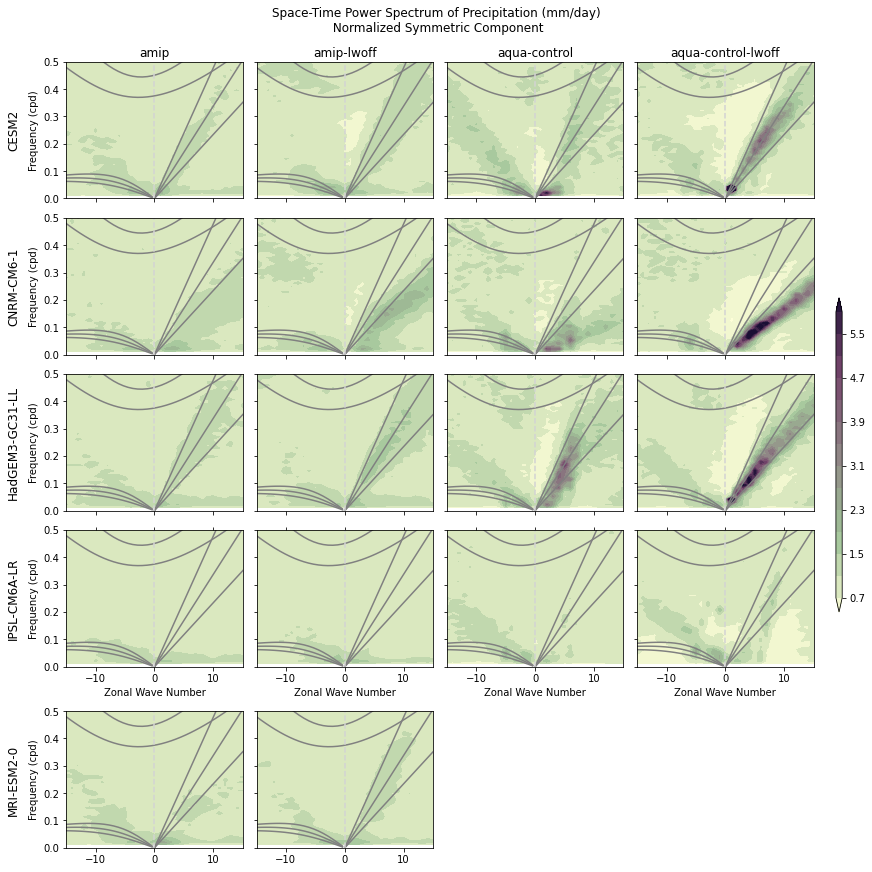

In [12]:
#
# Plot Normalized spectra together ...let's try one model per row [aqua, aqua-lwoff, amip, amip-lwoff]
#
fig, ax = plt.subplots(figsize=(12,12), ncols=4, nrows=5, constrained_layout=True, sharey=True, sharex=True)
cnorm = mpl.colors.Normalize(vmin=.10, vmax=6)
#
# CONTOURF VERSION
#
vmin = 0.3
vmax = 6.3
levels = 15
level_boundaries = np.linspace(vmin, vmax, levels + 1)
pad = 5 # in points

quads = []
for i, m in enumerate(models):
    if m not in results:
        [a.axis("off") for a in ax[i,:]]
        continue
    for j, ex in enumerate(["amip", "amip-lwoff", "aqua-control", "aqua-control-lwoff"]):
        if ex not in results[m]:
            ax[i,j].axis("off")
            continue
        z2_sym = results[m][ex][0]
#         z2_asy = results[m][ex][1]

        p0 = z2_sym.transpose().sel(frequency=slice(0,0.5), wavenumber=slice(-15,15))
#         p1 = nspec_asy.transpose().sel(frequency=slice(0,.5), wavenumber=slice(-15,15))
        p0.loc[{'frequency':0}] = np.nan
#         p1.loc[{'frequency':0}] = np.nan
        kmesh0, vmesh0 = np.meshgrid(p0['wavenumber'], p0['frequency'])
#         kmesh1, vmesh1 = np.meshgrid(p1['wavenumber'], p1['frequency'])
        # 
        # PCOLORMESH VERSION
        #
        # img0 = ax[0].pcolormesh(kmesh0, vmesh0, p0, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # img1 = ax[1].pcolormesh(kmesh1, vmesh1, p1, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # cb = fig.colorbar(img1, ax=ax.ravel())
        # CONTOURF
        quads.append(ax[i,j].contourf(
            kmesh0, vmesh0, p0, 
            level_boundaries,  # change this to `levels` to get the result that you want
            vmin=vmin, vmax=vmax, cmap=colormap, extend='both'
        ))
        for ii in range(3,6):
            c = 'gray'
            ax[i,j].plot(swk[ii, 0,:], swf[ii,0,:], color=c)
            ax[i,j].plot(swk[ii, 1,:], swf[ii,1,:], color=c)
            ax[i,j].plot(swk[ii, 2,:], swf[ii,2,:], color=c)
#         ax[i,j].set_title(f"{m}", loc='left')
#         ax[i,j].axhline(1/3, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/6, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/30, linestyle='dashed', color='lightgray')
        ax[i,j].axvline(0, linestyle='dashed', color='lightgray')
        ax[i,j].set_xlim([-15,15])
        ax[i,j].set_ylim([0,0.5])
        if i == 0:
            ax[i,j].annotate(ex, xy=(0.5, 1.), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
        if (j == 0):
            ax[i,j].annotate(m, xy=(0, .5), xytext=(-ax[i,j].yaxis.labelpad - pad, 0),
                xycoords=ax[i,j].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
            ax[i,j].set_ylabel("Frequency (cpd)")
        if (i == 3):
            ax[i,j].tick_params(axis='x', which='major',reset=True)
            ax[i,j].set_xlabel("Zonal Wave Number")


fig.colorbar(
    mpl.cm.ScalarMappable(norm=quads[-1].norm, cmap=quads[-1].cmap),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax.ravel(), shrink=0.4, extend='both'
)

fig.suptitle(f"Space-Time Power Spectrum of Precipitation (mm/day)\n Normalized Symmetric Component")
# a.set_xlabel("Zonal Wave Number")
# ax[0].set_ylabel("Frequency (cpd)")
# ax[0].set_title("Symmetric", loc='left')
# ax[1].set_title("Antisymmetric", loc='right')


# fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/amip_aqua_lwoff_wavfrq_symmetric_normalized.pdf", bbox_inches='tight')

Bbox(x0=0.78375, y0=0.2759999999999999, x1=0.8999999999999999, y1=0.729)
Bbox(x0=1.0, y0=0.2759999999999999, x1=1.03, y1=0.729)


Text(0.5, 0.98, 'Space-Time Power Spectrum of Precipitation (mm/day)\n Normalized Symmetric Component')

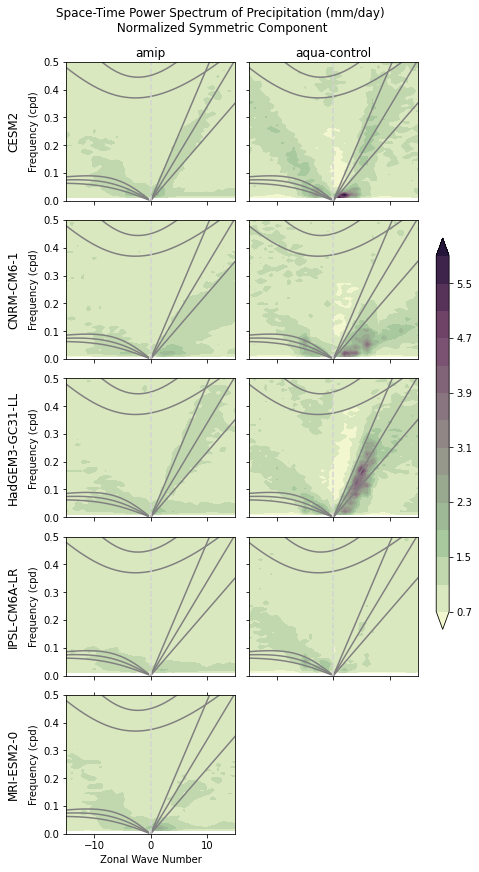

In [13]:
#
# Plot Normalized spectra together ...let's try one model per row [aqua, aqua-lwoff, amip, amip-lwoff]
#
fig, ax = plt.subplots(figsize=(6,12), ncols=2, nrows=5, constrained_layout=True, sharey=True, sharex=True)
cnorm = mpl.colors.Normalize(vmin=.10, vmax=6)
#
# CONTOURF VERSION
#
vmin = 0.3
vmax = 6.3
levels = 15
level_boundaries = np.linspace(vmin, vmax, levels + 1)
pad = 5 # in points

quads = []
for i, m in enumerate(models):
    if m not in results:
        [a.axis("off") for a in ax[i,:]]
        continue
    for j, ex in enumerate(["amip", "aqua-control"]):
        if ex not in results[m]:
            ax[i,j].axis("off")
            continue
        z2_sym = results[m][ex][0]
#         z2_asy = results[m][ex][1]

        p0 = z2_sym.transpose().sel(frequency=slice(0,0.5), wavenumber=slice(-15,15))
#         p1 = nspec_asy.transpose().sel(frequency=slice(0,.5), wavenumber=slice(-15,15))
        p0.loc[{'frequency':0}] = np.nan
#         p1.loc[{'frequency':0}] = np.nan
        kmesh0, vmesh0 = np.meshgrid(p0['wavenumber'], p0['frequency'])
#         kmesh1, vmesh1 = np.meshgrid(p1['wavenumber'], p1['frequency'])
        # 
        # PCOLORMESH VERSION
        #
        # img0 = ax[0].pcolormesh(kmesh0, vmesh0, p0, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # img1 = ax[1].pcolormesh(kmesh1, vmesh1, p1, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # cb = fig.colorbar(img1, ax=ax.ravel())
        # CONTOURF
        quads.append(ax[i,j].contourf(
            kmesh0, vmesh0, p0, 
            level_boundaries,  # change this to `levels` to get the result that you want
            vmin=vmin, vmax=vmax, cmap=colormap, extend='both'
        ))
        for ii in range(3,6):
            c = 'gray'
            ax[i,j].plot(swk[ii, 0,:], swf[ii,0,:], color=c)
            ax[i,j].plot(swk[ii, 1,:], swf[ii,1,:], color=c)
            ax[i,j].plot(swk[ii, 2,:], swf[ii,2,:], color=c)
#         ax[i,j].set_title(f"{m}", loc='left')
#         ax[i,j].axhline(1/3, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/6, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/30, linestyle='dashed', color='lightgray')
        ax[i,j].axvline(0, linestyle='dashed', color='lightgray')
        ax[i,j].set_xlim([-15,15])
        ax[i,j].set_ylim([0,0.5])
        if i == 0:
            ax[i,j].annotate(ex, xy=(0.5, 1.), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
        if (j == 0):
            ax[i,j].annotate(m, xy=(0, .5), xytext=(-ax[i,j].yaxis.labelpad - pad, 0),
                xycoords=ax[i,j].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
            ax[i,j].set_ylabel("Frequency (cpd)")
        if (i == len(models)-1):
            ax[i,j].tick_params(axis='x', which='major',reset=True)
            ax[i,j].set_xlabel("Zonal Wave Number")


cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=quads[-1].norm, cmap=quads[-1].cmap),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax.ravel(), shrink=0.6, extend='both'
)

# hacky way to position colorbar
cbpos = cb.ax.get_position()
print(cbpos)
cbpos.x0 = 1
cbpos.x1 = cbpos.x0+0.03
print(cbpos)
cb.ax.set_position(cbpos)

fig.suptitle(f"Space-Time Power Spectrum of Precipitation (mm/day)\n Normalized Symmetric Component")
# a.set_xlabel("Zonal Wave Number")
# ax[0].set_ylabel("Frequency (cpd)")
# ax[0].set_title("Symmetric", loc='left')
# ax[1].set_title("Antisymmetric", loc='right')


# fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/amip_aqua_wavfrq_symmetric_normalized.pdf", bbox_inches='tight')

Bbox(x0=0.78375, y0=0.2759999999999999, x1=0.8999999999999999, y1=0.729)
Bbox(x0=1.0, y0=0.2759999999999999, x1=1.03, y1=0.729)


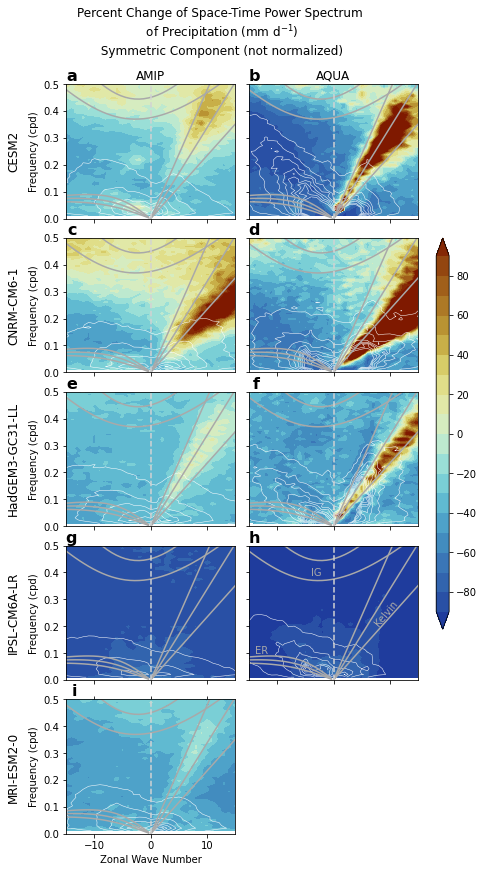

In [53]:
from palettable.scientific.diverging import Roma_20_r
divcolormap = Roma_20_r.mpl_colormap
#
# Plot Normalized spectra together ...let's try one model per row [aqua, aqua-lwoff, amip, amip-lwoff]
#
fig, ax = plt.subplots(figsize=(6,12), ncols=2, nrows=5, constrained_layout=True, sharey=True, sharex=True)
cnorm = mpl.colors.Normalize(vmin=.10, vmax=6)
#
# CONTOURF VERSION
#
vmin = -100
vmax =  100
levels = 20
level_boundaries = np.linspace(vmin, vmax, levels + 1)
pad = 5 # in points


cnLevels = [0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 ]
c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS
quads = []
cn = []
for i, m in enumerate(models):
    if m not in results:
        [a.axis("off") for a in ax[i,:]]
        continue
    for j, ex in enumerate(["amip", "aqua-control"]):
        if ex not in results[m]:
            ax[i,j].axis("off")
            continue
        z_sym = results_raw[m][ex][0]
        zraw = z_sym.transpose().sel(frequency=slice(0,0.5), wavenumber=slice(-15,15))
        
        z2_sym = results_raw[m][ex+"-lwoff"][0]
        
        z2_sym = 100.*(z2_sym - z_sym)/z_sym

        p0 = z2_sym.transpose().sel(frequency=slice(0,0.5), wavenumber=slice(-15,15))
#         p1 = nspec_asy.transpose().sel(frequency=slice(0,.5), wavenumber=slice(-15,15))
        p0.loc[{'frequency':0}] = np.nan
#         p1.loc[{'frequency':0}] = np.nan
        kmesh0, vmesh0 = np.meshgrid(p0['wavenumber'], p0['frequency'])
#         kmesh1, vmesh1 = np.meshgrid(p1['wavenumber'], p1['frequency'])
        # 
        # PCOLORMESH VERSION
        #
        # img0 = ax[0].pcolormesh(kmesh0, vmesh0, p0, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # img1 = ax[1].pcolormesh(kmesh1, vmesh1, p1, cmap='YlGnBu', norm=cnorm, shading='auto', rasterized=True)
        # cb = fig.colorbar(img1, ax=ax.ravel())
        # CONTOURF
        quads.append(ax[i,j].contourf(
            kmesh0, vmesh0, p0, 
            level_boundaries,  # change this to `levels` to get the result that you want
            vmin=vmin, vmax=vmax, cmap=divcolormap, extend='both'
        ))
        #
        # Here's where we add lines for the raw spectra
        #
        cn.append(ax[i,j].contour(kmesh0, vmesh0, zraw, levels=cnLevels, 
                                  colors='white', linewidths=0.5))

        for ii in range(3,6):
            ax[i,j].plot(swk[ii, 0,:], swf[ii,0,:], color=c)
            ax[i,j].plot(swk[ii, 1,:], swf[ii,1,:], color=c)
            ax[i,j].plot(swk[ii, 2,:], swf[ii,2,:], color=c)
#         ax[i,j].set_title(f"{m}", loc='left')
#         ax[i,j].axhline(1/3, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/6, linestyle='dashed', color='lightgray')
#         ax[i,j].axhline(1/30, linestyle='dashed', color='lightgray')
        ax[i,j].axvline(0, linestyle='dashed', color='lightgray')
        ax[i,j].set_xlim([-15,15])
        ax[i,j].set_ylim([0,0.5])
        if i == 0:
            ax[i,j].annotate(ex.split("-")[0].upper(), xy=(0.5, 1.), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
        if (j == 0):
            ax[i,j].annotate(m, xy=(0, .5), xytext=(-ax[i,j].yaxis.labelpad - pad, 0),
                xycoords=ax[i,j].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
            ax[i,j].set_ylabel("Frequency (cpd)")
        if (i == len(models)-1):
            ax[i,j].tick_params(axis='x', which='major',reset=True)
            ax[i,j].set_xlabel("Zonal Wave Number")

# some labels
ax[len(models)-2,1].text(7, .2, "Kelvin", color=c, rotation=50)
ax[len(models)-2,1].text(-14, .1, "ER", color=c, rotation=0)
ax[len(models)-2,1].text(-4, .39, "IG", color=c, rotation=0)


# FOR FINAL VERSION ADD PANEL LABELS:
from string import ascii_lowercase
axr = ax.ravel()
for i, label in enumerate(ascii_lowercase[0:len(ax.ravel())-1]):  # minus 1 because we have an empty panel
    addto = axr[i]
    addto.text(0.063, 1.115, label, transform=addto.transAxes,
      fontsize=16, in_layout=False, fontweight='bold', va='top', ha='right')


            
cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=quads[-1].norm, cmap=quads[-1].cmap),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax.ravel(), shrink=0.6, 
    extend='both'
)

cbpos = cb.ax.get_position()
print(cbpos)
cbpos.x0 = 1
cbpos.x1 = cbpos.x0+0.03
print(cbpos)
cb.ax.set_position(cbpos)

fig.suptitle("Percent Change of Space-Time Power Spectrum\n of Precipitation (mm d$^{-1}$)\n Symmetric Component (not normalized)")

# fig.savefig("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/amip_aqua_lwoff_wavfrq_symmetric_raw_percent_change_w_raw_contour.pdf", bbox_inches='tight')
fig.savefig("/Users/brianpm/Dropbox/Apps/Overleaf/cre_pex/Figure_5_final.pdf", bbox_inches='tight')

